In [1]:
import os
# !cd "data/"

# cwd1 = os.getcwd()
# print({cwd1})
# os.chdir(f"{cwd1}/data/")

# !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
# !wget http://www.ehu.eus/ccwintco/uploads/f/f1/Salinas.mat
# !wget http://www.ehu.eus/ccwintco/uploads/a/a3/Salinas_corrected.mat
# !wget http://www.ehu.eus/ccwintco/uploads/f/fa/Salinas_gt.mat
# #!wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
# # #!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
# !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
# # !wget http://www.ehu.eus/ccwintco/uploads/2/22/Indian_pines.mat
# # %cd ..
# # !pip install spectral
# # !pip install PyWavelets
# # !pip install np_utils
# # !pip install easyspc

# !cd ..

# os.chdir(f"{cwd1}")
# cwd = os.getcwd()
# print({cwd})

In [2]:
import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Conv2DTranspose, MaxPooling2D, MaxPooling3D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, Layer
from keras.layers import Dropout, Input, SeparableConv2D, LeakyReLU, GlobalAveragePooling2D,AveragePooling2D, MaxPooling2D, LeakyReLU, Add, Activation
from keras.regularizers import l2,l1
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
# from keras.utils import np_utils
# from plotly.offline import init_notebook_mode
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy
import os
import spectral
# from easyspc import SPC

# init_notebook_mode(connected=True)
# %matplotlib inline

2024-06-02 16:40:31.880704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 16:40:31.880725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 16:40:31.881426: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-02 16:40:31.885512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 16:40:32.593863: W tensorflow/compiler/tf2

ModuleNotFoundError: No module named 'spectral'

In [ ]:
## GLOBAL VARIABLES
dataset = "IP"
test_ratio = 0.80
windowSize = 11

def oversampleWeakClasses(X, y):
    """
    Oversample minority classes to balance the dataset.

    Args:
    X (numpy.ndarray): Input features.
    y (numpy.ndarray): Labels.

    Returns:
    tuple: Oversampled features and labels.
    """
    uniqueLabels, labelCounts = np.unique(y, return_counts=True)
    maxCount = np.max(labelCounts)
    labelInverseRatios = maxCount / labelCounts

    # Repeat for every label and concatenate
    newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
    newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)

    for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
        cX = X[y == label, :, :, :].repeat(round(labelInverseRatio), axis=0)
        cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
        newX = np.concatenate((newX, cX))
        newY = np.concatenate((newY, cY))

    # Shuffle the oversampled data
    np.random.seed(seed=42)
    rand_perm = np.random.permutation(newY.shape[0])
    newX = newX[rand_perm, :, :, :]
    newY = newY[rand_perm]

    return newX, newY

def loadData(name):
    """
    Load hyperspectral data based on the dataset name.

    Args:
    name (str): Name of the dataset ('IP', 'SA', or 'PU').

    Returns:
    tuple: Data and labels.
    """
    data_path = os.path.join(os.getcwd(), 'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    return data, labels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    """
    Split the dataset into training and testing sets.

    Args:
    X (numpy.ndarray): Input features.
    y (numpy.ndarray): Labels.
    testRatio (float): Ratio of test set size to total dataset size.
    randomState (int): Seed for random number generator.

    Returns:
    tuple: Training and testing data and labels.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def applyPCA(X, numComponents=75):
    """
    Apply Principal Component Analysis (PCA) to reduce dimensionality.

    Args:
    X (numpy.ndarray): Input data.
    numComponents (int): Number of principal components to keep.

    Returns:
    tuple: PCA-transformed data and PCA object.
    """
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin=2):
    """
    Pad the input data with zeros.

    Args:
    X (numpy.ndarray): Input data.
    margin (int): Padding size.

    Returns:
    numpy.ndarray: Padded data.
    """
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    """
    Create image cubes (patches) from the input data.

    Args:
    X (numpy.ndarray): Input data.
    y (numpy.ndarray): Labels.
    windowSize (int): Size of the image cube.
    removeZeroLabels (bool): Whether to remove patches with zero labels.

    Returns:
    tuple: Image cubes and corresponding labels.
    """
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # Split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [4]:
# Load the dataset
X, y = loadData(dataset)
print(X.shape)

# Set the number of components for PCA
K = 100 if dataset == 'IP' else 40
print(X.shape)

# Apply PCA to reduce dimensionality
X, pca = applyPCA(X, numComponents=K)
print(X.shape)

# Update K to the actual number of components after PCA
K = X.shape[2]
print(X.shape)

# Create image cubes (patches) from the data
X, y = createImageCubes(X, y, windowSize=windowSize)
print(X.shape)

# Split the data into training and testing sets
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
print(Xtrain.shape)

(145, 145, 200)
(145, 145, 200)
(145, 145, 100)
(145, 145, 100)
(10249, 11, 11, 100)
(2049, 11, 11, 100)


In [5]:
# Oversample minority classes in the training data
Xtrain, ytrain = oversampleWeakClasses(Xtrain, ytrain)
print(Xtrain.shape)

# Reshape the training data to include a channel dimension
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
print(Xtrain.shape)

# Convert labels to one-hot encoded format
ytrain = to_categorical(ytrain)

# Set variables for model architecture
S = windowSize  # Spatial dimension of input patches
L = K  # Spectral dimension (number of channels after PCA)

# Set the number of output units based on the dataset
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

(7919, 11, 11, 100)
(7919, 11, 11, 100, 1)


In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, MultiHeadAttention, LayerNormalization, Dropout

def sandwich_block(x, filters, kernel_size=(3, 3), pool_size=(2, 2), use_pooling=True, dropout_rate=0.0):
    """
    Create a sandwich block consisting of Convolution, BatchNormalization, and LeakyReLU,
    optionally followed by MaxPooling and Dropout.

    Args:
    x (tensor): Input tensor
    filters (int): Number of filters for the convolutional layer
    kernel_size (tuple): Size of the convolutional kernel
    pool_size (tuple): Size of the pooling window
    use_pooling (bool): Whether to use MaxPooling
    dropout_rate (float): Dropout rate (0.0 means no dropout)

    Returns:
    tensor: Output tensor after applying the sandwich block
    """
    # Convolutional layer
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(x)

    # Batch normalization
    x = BatchNormalization()(x)

    # LeakyReLU activation
    x = LeakyReLU()(x)

    # Optional max pooling
    if use_pooling:
        x = MaxPooling2D(pool_size=pool_size)(x)

    # Optional dropout
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    return x


In [7]:
from tensorflow.keras.layers import Input, Conv3D, Reshape, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Define input layer
input_layer = Input((S, S, L, 1))

# 3D Convolutional layers
x = Conv3D(filters=32, kernel_size=(3, 3, 7), activation='relu')(input_layer)
x = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(x)
x = Conv3D(filters=8, kernel_size=(3, 3, 5), activation='relu')(x)

# Reshape the output to 2D
x_shape = x.shape
x = Reshape((x_shape[1], x_shape[2], x_shape[3]*x_shape[4]))(x)

# First sandwich block
x = sandwich_block(x, filters=64, kernel_size=(3, 3), pool_size=(2, 2), use_pooling=False)

# Self-attention layer
attn_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
attn_output = LayerNormalization(epsilon=1e-6)(attn_output + x)

# Second sandwich block
x = sandwich_block(x, filters=32, kernel_size=(3, 3), pool_size=(2, 2), use_pooling=True)

# Dropout layer
x = Dropout(0.4)(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)

# Flatten the output
x = Flatten()(x)

# Dense layers
x = Dense(units=256, activation='relu')(x)
x = LeakyReLU()(x)
x = Dropout(0.4)(x)

x = Dense(units=128, activation='relu')(x)
x = LeakyReLU()(x)

# Output layer
output_layer = Dense(units=output_units, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

2024-06-02 16:29:32.676488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 16:29:32.705329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 16:29:32.705468: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Define the optimizer
adam = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

# Define the filepath for saving the best model
filepath = f"best-model-{dataset}.keras"

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath,
                             monitor='acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

# Create a list of callbacks
callbacks_list = [checkpoint]

In [9]:
# Train the model
history = model.fit(
    x=Xtrain,          # Input data
    y=ytrain,          # Target labels
    batch_size=256,    # Number of samples per gradient update
    epochs=10,         # Number of times to iterate over the entire dataset
    callbacks=callbacks_list  # List of callbacks to apply during training
)

Epoch 1/10


2024-06-02 16:29:34.535195: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-02 16:29:34.695519: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-06-02 16:29:37.757619: I external/local_xla/xla/service/service.cc:168] XLA service 0x7eff52db9380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-02 16:29:37.757642: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-02 16:29:37.766871: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717302577.851320 1489894 device_compiler.h:186] Compiled cluster using XLA!  T

31/31 [==============================] - ETA: 0s - loss: 1.4182 - acc: 0.6222
Epoch 1: acc improved from -inf to 0.62217, saving model to best-model-IP.keras
31/31 [==============================] - 21s 407ms/step - loss: 1.4182 - acc: 0.6222
Epoch 2/10
31/31 [==============================] - ETA: 0s - loss: 0.1398 - acc: 0.9641
Epoch 2: acc improved from 0.62217 to 0.96414, saving model to best-model-IP.keras
31/31 [==============================] - 6s 199ms/step - loss: 0.1398 - acc: 0.9641
Epoch 3/10
31/31 [==============================] - ETA: 0s - loss: 0.0223 - acc: 0.9968
Epoch 3: acc improved from 0.96414 to 0.99684, saving model to best-model-IP.keras
31/31 [==============================] - 6s 203ms/step - loss: 0.0223 - acc: 0.9968
Epoch 4/10
31/31 [==============================] - ETA: 0s - loss: 0.0174 - acc: 0.9968
Epoch 4: acc did not improve from 0.99684
31/31 [==============================] - 6s 198ms/step - loss: 0.0174 - acc: 0.9968
Epoch 5/10
31/31 [============

In [10]:
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report

# Load the best model weights
model.load_weights(f"best-model-{dataset}.keras")

# Recompile the model
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Reshape the test data to match the input shape of the model
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)

# Convert test labels to one-hot encoded format
ytest = to_categorical(ytest)

# Make predictions on the test set
Y_pred_test = model.predict(Xtest)

# Convert predictions from one-hot encoded to class labels
y_pred_test = np.argmax(Y_pred_test, axis=1)

# Generate classification report
classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)

# Print the classification report
print(classification)

257/257 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        37
           1       0.98      0.99      0.99      1143
           2       0.99      0.96      0.98       664
           3       0.99      1.00      1.00       190
           4       0.97      1.00      0.98       386
           5       1.00      0.99      1.00       584
           6       1.00      1.00      1.00        22
           7       0.99      1.00      0.99       382
           8       0.84      1.00      0.91        16
           9       0.97      0.99      0.98       778
          10       1.00      0.96      0.98      1964
          11       0.92      0.99      0.96       475
          12       1.00      1.00      1.00       164
          13       0.98      1.00      0.99      1012
          14       1.00      0.97      0.99       309
          15       0.97      1.00      0.99        74

    accuracy             

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score

def AA_andEachClassAccuracy(confusion_matrix):
    """
    Calculate average accuracy and accuracy for each class from a confusion matrix.
    """
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(np.divide(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def reports(X_test, y_test, name):
    """
    Generate comprehensive classification report including various metrics.
    """
    # Predict and get class labels
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)

    # Set target names based on dataset
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn',
                        'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    # Generate classification report and other metrics
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss = score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

# Generate report
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest, ytest, dataset)
print(each_acc)

# Write report to file
file_name = f"classification_report-{dataset}.txt"
with open(file_name, 'w') as x_file:
    x_file.write(f'{Test_loss} Test loss (%)\n')
    x_file.write(f'{Test_accuracy} Test accuracy (%)\n\n')
    x_file.write(f'{kappa} Kappa accuracy (%)\n')
    x_file.write(f'{oa} Overall accuracy (%)\n')
    x_file.write(f'{aa} Average accuracy (%)\n\n')
    x_file.write(f'{classification}\n')
    x_file.write(f'{confusion}\n')

# Display the contents of the report file
!cat {file_name}

257/257 [==============================] - 3s 12ms/step - loss: 0.0537 - accuracy: 0.9835
[100.          99.38757655  96.38554217 100.          99.74093264
  99.48630137 100.         100.         100.          98.58611825
  96.07942974  99.15789474 100.         100.          97.41100324
 100.        ]
cat: classification_report.txt: No such file or directory


In [ ]:
import numpy as np

def Patch(data, height_index, width_index):
    """
    Extract a patch from the data centered at the given indices.
    """
    height_slice = slice(height_index, height_index + PATCH_SIZE)
    width_slice = slice(width_index, width_index + PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

# Load and preprocess the data
X, y = loadData(dataset)
height, width = y.shape[:2]
PATCH_SIZE = windowSize
numComponents = K

# Apply PCA
X, pca = applyPCA(X, numComponents=numComponents)

# Pad the data
X = padWithZeros(X, PATCH_SIZE // 2)

# Initialize output array
outputs = np.zeros((height, width))

# Iterate over each pixel in the image
for i in range(height):
    for j in range(width):
        target = int(y[i, j])
        if target == 0:
            continue
        else:
            # Extract patch
            image_patch = Patch(X, i, j)

            # Reshape patch for model input
            X_test_image = image_patch.reshape(1, image_patch.shape[0], image_patch.shape[1], image_patch.shape[2], 1).astype('float32')

            # Make prediction
            prediction = model.predict(X_test_image)
            prediction = np.argmax(prediction, axis=1)

            # Store prediction
            outputs[i][j] = prediction + 1

1/1 [==============================] - 0s 12ms/step


/tmp/ipykernel_1489771/1954029800.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  outputs[i][j] = prediction+1


1/1 [==============================] - 0s 12ms/step


In [13]:
import spectral

ground_truth = spectral.imshow(classes=y, figsize=(10,10))

NameError: name 'spectral' is not defined

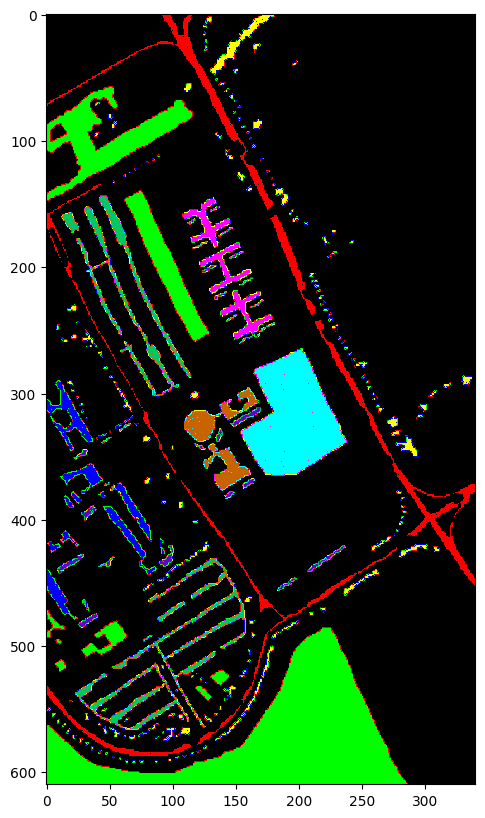

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(10,10))

In [ ]:
import spectral

name = f"image_{dataset}.pdf"
spectral.save_rgb(name, outputs.astype(int), colors=spectral.spy_colors)